**Two point boundary value problem - Relaxation method**

http://web.mit.edu/hyperbook/Patrikalakis-Maekawa-Cho/node197.html

2D Test problem : A basic second order ODE with Dirichlet boundary conditions 

$$\frac{d^2y}{dx^2}=f(x) \quad , \quad x\in[0,1] \quad$$
$$y(0)=y_0 \quad , \quad y(1)=y_1$$


Let's first use : $f(x)=1+2x , y_0=0 , y_1=5$

The analytical solution is $y(x) = \frac{25}{6}x+\frac{x^2}{2}+\frac{x^3}{3}$


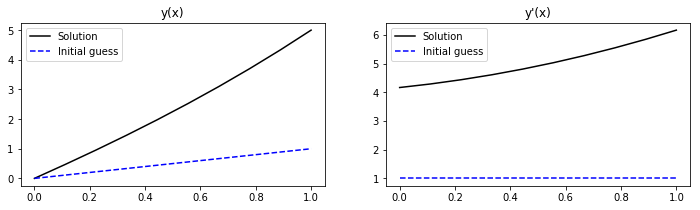

In [203]:
import numpy as np
from numpy import array,linspace,ones
import matplotlib.pyplot as plt

m = 10 # grid points 
x = linspace(0,1,m)

# y1 is y, y2=y1'   (such as to make a coupled ODE problem)
y1_ana = 25/6*x+x**2/2+x**3/3  # analytical solution
y2_ana = 25/6+x+x**2
y1_init = x
y2_init = ones(m)
# y1_init = np.sin(x)
# y2_init = np.cos(x)

def stack_y(y1,y2): # gives y = [ y1_0,y2_0 , y1_1,y2_1, ... , y1_m,y2_m] (what is used in solving the matrix system)
    y = []
    for i in range(m):
        y.append(y1[i])
        y.append(y2[i])
    return array(y)

def unstack_y(y):   # gives y1 and y2, the m-points arrays
    y1,y2= [],[]
    for i in range(m):
        y1.append(y[2*i])
        y2.append(y[2*i+1])
    return np.array(y1),np.array(y2)

def get_yk(y,k):     # gives Y_k = (y1_k,y2_k), which is the input needed for G(x,y)
    y1,y2 = unstack_y(y)
    return [y1[k],y2[k]]

def plot_window():
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,3))
    ax1.plot(x,y1_ana,'k-',label='Solution')
    ax1.plot(x,y1_init,'b--',label='Initial guess')
    ax2.plot(x,y2_ana,'k-',label='Solution')
    ax2.plot(x,y2_init,'b--',label='Initial guess')
    ax1.set_title('y(x)')
    ax2.set_title("y'(x)")
    ax1.legend()
    ax2.legend()
    return fig,ax1,ax2
_=plot_window()

y_init = stack_y(y1_init,y2_init)

In [217]:
# Algorithm

# BCs
alpha = 0 
beta  = 5

def G(xk,y): # RHS of dY/dx=G(x).  Expecting y to be [y1(x),y2(x)] 
    return [y[1] , 1+2*xk]

def Err(y): # error vector. Expecting y to be the m-stacked y1,y2 
    y1,y2 = unstack_y(y)
    F0,Fend = y1[0]-alpha , y1[-1]-beta
#     F = [F0,0]
    F=[F0]
    for k in range(1,m):
        
        yk,ykm1 = get_yk(y,k) , get_yk(y,k-1)
        Gk   = G(x[k] , yk)
        Gkm1 = G(x[k-1] , ykm1)
        
        for i in range(2):
            Fk = (yk[i] - ykm1[i])/(x[k]-x[k-1]) - 0.5*(Gk[i] + Gkm1[i])
            F.append(Fk)

#     F.extend([0,Fend])
#     F.extend([Fend,0])
    F.append(Fend)
        
    return array(F)

def Jac_approx(func,ya,yb): # jacobian from finite difference derivatives (needs two points)
    
    def Jmunu(mu,nu): # returns approximate of dF_mu/dy_nu
        num   = func([ya[i] if i!=nu else yb[i] for i in range(2*m)])[mu] - func(ya)[mu]
        den   = yb[nu]-ya[nu]
#         prit(num)
#         print(array([ya[i] if i!=nu else yb[i] for i in range(2*m)]) - array(ya))
#         print(func([ya[i] if i!=nu else yb[i] for i in range(2*m)]) - func(ya))
        return num/den
    
    J = np.zeros((2*m,2*m)) # initialize matrix
    for mu in range(2*m):
        for nu in range(2*m):
            J[mu][nu] = Jmunu(mu,nu)
            
    return J

def Jac_exact(y): # exact jacobian (problem specificc)
    pass
    
            
def Newton(func,ya,yb,nmax=100,**kwargs):
    
    n,go = 1,1
    sols = [ya]
    while go:
        
        sols.append(yb)
        print(n)
        J = Jac_approx(func,ya,yb)
        print(np.linalg.det(J))
        ynew = yb - np.matmul(np.linalg.inv(J) , func(yb))
        
        ya = yb[:]
        yb = ynew[:]
   
        err = np.linalg.norm(yb-ya)
#         print(err)
        if err<1e-10:
            go=0
            print('Converged after %d iterations'%n)
            
        n+=1
        if n==nmax:
            go=0
                
    return sols,n
    
ya,yb = y_init,2*y_init*np.exp(y_init)+1
sols,niter=Newton(Err,ya,yb,nmax=20)

1
1.500946352970003e+17
2
1.500946352970003e+17
Converged after 2 iterations


In [218]:
from matplotlib import animation, rc
from IPython.display import HTML

fig,ax1,ax2=plot_window()
plt.close()
line1, = ax1.plot([], [], lw=2,color='r')
line2, = ax2.plot([], [], lw=2,color='r')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1,line2,)

def animate(i):
    y1,y2 = unstack_y(sols[i])
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    fig.suptitle('iteration '+str(i))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=niter, interval=20, blit=True)

In [219]:
HTML(anim.to_html5_video())